In [5]:
%matplotlib inline

import re
import sqlite3
from dataclasses import dataclass, field
from datetime import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

from release import Release


con = sqlite3.connect('main.db')

line_style = dict(textcoords="offset points",
                    horizontalalignment="right")
major_style = dict(
        size=10, ha="center", va="center",
        bbox=dict(boxstyle="circle,pad=0.3", fc="cyan", ec="b", lw=2)
)

In [6]:

project_name = 'mysql'

sql = f'''
select tag, date(creator_dt)
from projects join releases on projects.id = releases.project_id
where name = '{project_name}'
order by 2
'''
raw_releases = con.execute(sql).fetchall()

raw_releases = [Release(tag, date) for tag,date in raw_releases]
print(f'{len(raw_releases)=}')
# assert 0, [raw_releases[:3]]


len(raw_releases)=713


In [7]:
# remove uninteresting releases

def get_interesting(raw_rels):
    """
    show only the first major.minor; ignore RC and all other micro versions
    """
    already_seen = set()
    for rel in raw_releases:
            mm = rel.majormin
            if mm in already_seen:
                    continue
            # TODO: skip micro releases
            if not rel.date:
                    # print(f'?? {rel=}')
                    continue
            already_seen.add(mm)
            yield rel

releases = list(get_interesting(raw_releases))
print(f'{len(releases)=}')
# assert 0, releases[:3]


len(releases)=16


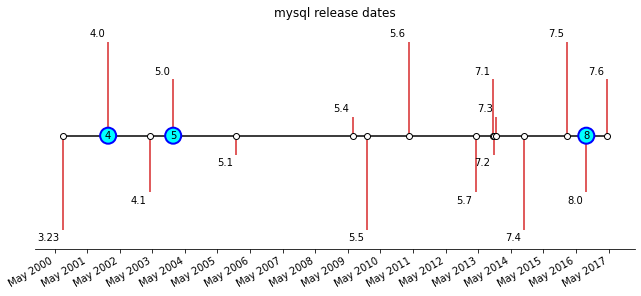

In [12]:

# Choose some nice levels
raw_levels = [-5, 5, -3, 3, -1, 1]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
ax.set(title=f"{project_name} release dates")

dates = [rel.date for rel in releases]
if 1:
        # The vertical stems.
        levels = np.tile(raw_levels,
                 int(np.ceil(len(dates)/6)))[:len(dates)]
        ax.vlines(x=dates, ymin=0, ymax=levels, color="tab:red")  

# Baseline and markers on it.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")  

# annotate lines
for num,rel in enumerate(releases):
        level = raw_levels[num % len(raw_levels)]
        valign = "bottom" if level > 0 else "top"
        xytext = (-3, np.sign(level)*3)
        ax.annotate(rel.majormin, xy=(rel.date, level),
                        xytext=xytext,
                        verticalalignment=valign,
                        **line_style)

# major releases get big blue circle
major_pat = re.compile(r'([0-9]+)\.0')
for rel in releases:
        match = major_pat.match(rel.majormin)
        if not match:
                continue
        label = match.group(1)  # "major" (no minor nor micro)
        ax.text(rel.date, 0, label, **major_style)

# format xaxis with intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()